## Human In Loop

In [ ]:
from dotenv import load_dotenv
load_dotenv()

In [1]:
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="deepseek-r1-distill-llama-70b")

llm.invoke("What is the capital of France?")


AIMessage(content='<think>\n\n</think>\n\nThe capital of France is Paris.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 10, 'total_tokens': 22, 'completion_time': 0.046422739, 'prompt_time': 0.000203417, 'queue_time': 0.202299828, 'total_time': 0.046626156}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--0df7b5fd-a9ca-44e5-965b-3d3e5e491f29-0', usage_metadata={'input_tokens': 10, 'output_tokens': 12, 'total_tokens': 22})

### Tools

In [2]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
@tool
def multiply(x: int, y: int) -> int:
    """Multiplies two numbers."""
    return x * y

@tool
def search(query: str):
    """search the web for a query and return the results"""
    tavily=TavilySearchResults()
    result=tavily.invoke(query)
    return f"Result for {query} is: \n{result}"

In [6]:
tools = [multiply, search]
tools

[StructuredTool(name='multiply', description='Multiplies two numbers.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000025DA918A2A0>),
 StructuredTool(name='search', description='search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000025DA9448EA0>)]

In [7]:
llm_with_tools=llm.bind_tools(tools)

In [8]:
result=llm_with_tools.invoke("what is current gdp of india?")

In [9]:
result.tool_calls


[{'name': 'search',
  'args': {'query': 'current GDP of India'},
  'id': 'ndm2r3fgs',
  'type': 'tool_call'}]

In [10]:
result.tool_calls[0]["name"]


'search'

In [11]:
result.tool_calls[0]["args"]

{'query': 'current GDP of India'}

In [12]:
type(result.tool_calls[0]["args"])

dict

In [13]:
tool_mapping={tool.name:tool for tool in tools}

tool_mapping

{'multiply': StructuredTool(name='multiply', description='Multiplies two numbers.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000025DA918A2A0>),
 'search': StructuredTool(name='search', description='search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000025DA9448EA0>)}

In [14]:
tool_mapping["search"]

StructuredTool(name='search', description='search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000025DA9448EA0>)

In [15]:
tool_mapping["search"].invoke({"query":"What is the capital of india?"})

'Result for What is the capital of india? is: \n[{\'title\': \'Which City became the capital of India for a day, Check here\', \'url\': \'https://www.jagranjosh.com/general-knowledge/which-city-became-the-capital-of-india-for-a-day-1731421925-1\', \'content\': \'If someone asks you what is the capital of India, you will answer that it is New Delhi, which the British established. In Indian history, the capital of the country changed many times and different cities got the honour of becoming the capital of the country. [...] ## If you are asked what the capital of India is, your answer will be New Delhi, which was settled by the British. Do you know that once in Indian history, a district was made the capital of the country? However, this incident lasted only for a day, after which it was recorded in the pages of history forever. This article will introduce you to one such district in India.\\n\\nByKishan Kumar\\n\\nNov 12, 2024, 20:03 IST\\n\\none day capital of India [...] After making

In [16]:
tool_mapping[result.tool_calls[0]["name"]].invoke(result.tool_calls[0]["args"])

'Result for current GDP of India is: \n[{\'title\': \'India Becoming An Economic Powerhouse - PIB\', \'url\': \'https://www.pib.gov.in/PressNoteDetails.aspx?NoteId=154660\', \'content\': \'India’s GDP has witnessed a remarkable transformation over the past decade. At current prices, GDP has increased from ₹106.57 lakh crore in 2014–15 to an estimated ₹331.03 lakh crore in 2024–25, an approximate threefold rise in just ten years. In 2024–25 alone, nominal GDP grew by 9.9% over the previous year, while real GDP (at constant prices) increased by 6.5%, reflecting sustained economic momentum. This steep growth reflects the country’s expanding economic base and rising income levels. [...] India, the world’s fourth-largest economy, has emerged as the fastest-growing major economy and is on track to become the world’s third-largest economy with a projected GDP of $7.3 trillion by 2030. India is projected to be world’s fastest growing major economy (6.3% to 6.8% in 2025-26). This transformation

### Agent

In [17]:
from typing import TypedDict, Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage

In [18]:
class AgentState(TypedDict):
    """State for the agent."""
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [19]:
def invoke_model(state:AgentState):
    messages=state["messages"]
    question=messages[-1]
    response=llm_with_tools.invoke(question)
    return {"messages":[response]}

In [20]:
def router(state:AgentState):
    tool_calls=state["messages"][-1].tool_calls
    if len(tool_calls)>0:
        return "tool" #key name
    else:
        return "end" #key name

In [21]:
def invoke_tool(state:AgentState):
    tool_details=state["messages"][-1].tool_calls
    
    if tool_details is None:
        return Exception("No tool calls found in the last message.")
    
    print(f"Seleted tool: {tool_details[0]['name']}")
    
    if tool_details[0]["name"]=="search":
        response=input(prompt=f"[yes/no] do you want to continue with this expensive web search")
        if response.lower()=="no":
            print("web search discarded by the user. exiting gracefully")
            raise Exception("Web search discarded by the user.")
            
    
    response=tool_mapping[tool_details[0]["name"]].invoke(tool_details[0]["args"])
    return {"messages":[response]}

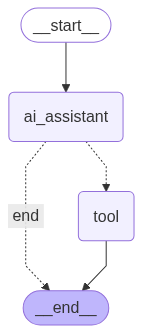

In [22]:
from langgraph.graph import StateGraph, START,END

graph=StateGraph(AgentState)

graph.add_node("ai_assistant", invoke_model)

# eariler we were using the tool node from list of tool
# but now we have crate tool invoke(custom funtion)
# why we are doing it: as a user if we want to take a authority to which i need to give permission for execution

graph.add_node("tool", invoke_tool)

graph.add_conditional_edges("ai_assistant",
                            router,
                            {
                                "tool":"tool", ##with the key tool which value is associated <tool>
                                "end":END
                            }
                            )

graph.add_edge("tool", END)

graph.set_entry_point("ai_assistant")

app=graph.compile()

app

In [23]:
app.invoke({"messages":["What is the current gdp of the india?"]})

Seleted tool: search


{'messages': ['What is the current gdp of the india?',
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the current GDP of India. I need to figure out how to get that information. I remember that I have a tool called "search" which can look up information on the web. So, I should use that tool with the query "current GDP of India" to find the most accurate and up-to-date data. I\'ll format the tool call correctly with the function name as "search" and the query as a string. That should help the user get the information they\'re looking for.\n', 'tool_calls': [{'id': 'e80kkcrq1', 'function': {'arguments': '{"query":"current GDP of India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 176, 'total_tokens': 312, 'completion_time': 0.580744605, 'prompt_time': 0.012195183, 'queue_time': 0.20226217700000002, 'total_time': 0.592939788}, 'model_name': 'deepseek-r1-distill-lla

### Human In Loop Use Case 2: Take User Input and Integrate in Workflow

In [25]:
tools

[StructuredTool(name='multiply', description='Multiplies two numbers.', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x0000025DA918A2A0>),
 StructuredTool(name='search', description='search the web for a query and return the results', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000025DA9448EA0>)]

In [26]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node=ToolNode(tools)

In [28]:
llm_with_tools=llm.bind_tools(tools)

In [27]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [35]:
def ai_assistant(state: AgentState):
    response=llm_with_tools.invoke(state["messages"])
    return {"messages":[response]}

In [30]:
from langgraph.checkpoint.memory import MemorySaver

memory=MemorySaver()

In [38]:
graph_builder=StateGraph(AgentState)
graph_builder.add_node("ai_assistant", ai_assistant)
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge(START,"ai_assistant")
graph_builder.add_conditional_edges("ai_assistant",
                                    tools_condition,
                                    )
graph_builder.add_edge("tools", "ai_assistant")

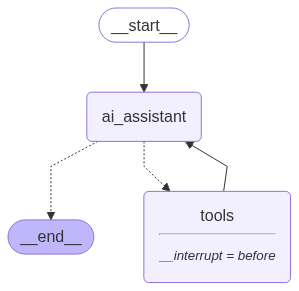

In [39]:
app2=graph_builder.compile(checkpointer=memory,interrupt_before=["tools"])
app2

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

config={"configurable":{"thread_id":"1"}}
response=app2.invoke({"messages":[HumanMessage("What is the current gdp of the china?")]},config=config)

In [41]:
response

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking about the current GDP of China. Since I don't have real-time data, I'll need to use the 'search' tool to find the most recent information. I should structure the search query clearly to get accurate results. Let me call the search function with the appropriate parameters.\n", 'tool_calls': [{'id': '583d8cnet', 'function': {'arguments': '{"query":"current GDP of China 2023"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 198, 'total_tokens': 289, 'completion_time': 0.377996959, 'prompt_time': 

In [42]:
# Captures the State

snapshot=app2.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}), HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}), HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking about the current GDP of China. Since I don't have real-time data, I'll need to use the 'search' tool to find the most recent information. I should structure the search query clearly to get accurate results. Let me call the search function with the appropriate parameters.\n", 'tool_calls': [{'id': '583d8cnet', 'function': {'arguments': '{"query":"current GDP of China 2023"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 198, 'total_tokens': 289, 'completion_time': 0.377996959, 

In [43]:
# Tells which Tool is being called
snapshot.next

('tools',)

In [44]:
# Tells the last message in the State (AI Message)

last_message = snapshot.values["messages"][-1]
last_message

AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking about the current GDP of China. Since I don't have real-time data, I'll need to use the 'search' tool to find the most recent information. I should structure the search query clearly to get accurate results. Let me call the search function with the appropriate parameters.\n", 'tool_calls': [{'id': '583d8cnet', 'function': {'arguments': '{"query":"current GDP of China 2023"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 198, 'total_tokens': 289, 'completion_time': 0.377996959, 'prompt_time': 0.026880267, 'queue_time': 0.21762821100000002, 'total_time': 0.404877226}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8aefdd3d-094d-444d-888b-3aadb15bb7cd-0', tool_calls=[{'name': 'search', 'args': {'query': 'current GDP of China 2023'}, 

In [45]:
# Gives the tool call of the last message

tool_details = last_message.tool_calls
tool_details

[{'name': 'search',
  'args': {'query': 'current GDP of China 2023'},
  'id': '583d8cnet',
  'type': 'tool_call'}]

In [46]:
tool_details[0]["name"]

'search'

In [47]:
# Handling the Human in loop now, asking user what to do and getting approval

if tool_details[0]["name"]== "search":
    user_input = input(prompt=f"[yes/no] do you want to continue with {tool_details[0]['name']}?").lower()
    if user_input=="no":
        print("web tool discarded")
        raise Exception("Web tool discarded by the user.")
    else:
        response=app2.invoke(None,config) # None continues the state(removes interruption)
        print(response)
else:
    response=app2.invoke(None,config)
    print(response)

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}), HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}), HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking about the current GDP of China. Since I don't have real-time data, I'll need to use the 'search' tool to find the most recent information. I should structure the search query clearly to get accurate results. Let me call the search function with the appropriate parameters.\n", 'tool_calls': [{'id': '583d8cnet', 'function': {'arguments': '{"query":"current GDP of China 2023"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 198, 'total_tokens': 289, 'completion_time': 0.377996959, 'prompt_time': 0.0268

In [49]:
# None to handle removing human intervention

app2.invoke(None,config) #none means resume the last state or resume the process

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking about the current GDP of China. Since I don't have real-time data, I'll need to use the 'search' tool to find the most recent information. I should structure the search query clearly to get accurate results. Let me call the search function with the appropriate parameters.\n", 'tool_calls': [{'id': '583d8cnet', 'function': {'arguments': '{"query":"current GDP of China 2023"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 198, 'total_tokens': 289, 'completion_time': 0.377996959, 'prompt_time': 

#### Adding Human Input into the flow

In [51]:
response=app2.invoke({"messages":[HumanMessage("What is the current gdp of the japan?")]},config=config)
response

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking about the current GDP of China. Since I don't have real-time data, I'll need to use the 'search' tool to find the most recent information. I should structure the search query clearly to get accurate results. Let me call the search function with the appropriate parameters.\n", 'tool_calls': [{'id': '583d8cnet', 'function': {'arguments': '{"query":"current GDP of China 2023"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 198, 'total_tokens': 289, 'completion_time': 0.377996959, 'prompt_time': 

In [52]:
snapshot=app2.get_state(config)
snapshot.next

('tools',)

In [53]:
last_message=snapshot.values["messages"][-1]
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'current GDP of Japan 2025'},
  'id': 'n2j2z8ewz',
  'type': 'tool_call'}]

In [54]:
tool_call_id=last_message.tool_calls[0]["id"]
tool_call_id

'n2j2z8ewz'

In [55]:
new_message=[
    ToolMessage(content="according to the latest data 4.1 trillion USD", tool_call_id=tool_call_id),
]

In [56]:
app2.update_state(config,
                  {
                      "messages": new_message
                  })

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f070bb6-c2f9-640f-8012-1daade2f9282'}}

In [57]:
app2.get_state(config).values["messages"][-1]

ToolMessage(content='according to the latest data 4.1 trillion USD', tool_call_id='n2j2z8ewz')

In [58]:
app2.invoke(None,config=config)

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking about the current GDP of China. Since I don't have real-time data, I'll need to use the 'search' tool to find the most recent information. I should structure the search query clearly to get accurate results. Let me call the search function with the appropriate parameters.\n", 'tool_calls': [{'id': '583d8cnet', 'function': {'arguments': '{"query":"current GDP of China 2023"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 198, 'total_tokens': 289, 'completion_time': 0.377996959, 'prompt_time': 

In [59]:
app2.invoke({"messages":[HumanMessage("What is the current gdp of the japan?")]},config=config)

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking about the current GDP of China. Since I don't have real-time data, I'll need to use the 'search' tool to find the most recent information. I should structure the search query clearly to get accurate results. Let me call the search function with the appropriate parameters.\n", 'tool_calls': [{'id': '583d8cnet', 'function': {'arguments': '{"query":"current GDP of China 2023"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 198, 'total_tokens': 289, 'completion_time': 0.377996959, 'prompt_time': 

In [60]:
app2.invoke(None,config=config)

{'messages': [HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='What is the current gdp of the china?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking about the current GDP of China. Since I don't have real-time data, I'll need to use the 'search' tool to find the most recent information. I should structure the search query clearly to get accurate results. Let me call the search function with the appropriate parameters.\n", 'tool_calls': [{'id': '583d8cnet', 'function': {'arguments': '{"query":"current GDP of China 2023"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 198, 'total_tokens': 289, 'completion_time': 0.377996959, 'prompt_time': 